## Прогнозирование временных рядов на карте

![Yellow Taxi](https://www1.nyc.gov/assets/tlc/images/content/pages/home/218-yellow-cab.jpg)

### Неделя 6 - Дополнительные признаки

**1. Загрузите обучающие выборки прошлой недели, перечислите используемые в моделях признаки и посчитайте $Q_{may}$ — качество прогнозов моделей, настроенных на данных до апреля 2016, в мае 2016.**

На прошлой неделе использовались следующие признаки:
* количество поездок в текущий час;
* количество поездок с часовыми лагами с 1 по 23;
* количество поездок с суточными лагами с 1 по 7;
* переменная для номера года (номер года минус 2009);
* 12 dummy-переменных для месяцев;
* 31 dummy-переменная для номера дня;
* 7 dummy-переменных для дня недели;
* 24 dummy-переменных для номера часа;
* 10 dummy-переменных для признаков государственных праздников в США;
* среднее количество поездок за последние 3 часа;
* среднее количество поездок за последние 6 часов;
* среднее количество поездок за последние 12 часов;
* среднее количество поездок за последние 24 часа;
* среднее количество поездок за последние 7 дней;
* среднее количество поездок за последние 30 дней;
* 14 переменных для недельных гармоник;
* 30 переменных для годовых гармоник.

Кроме того, в данных были предусмотрены переменные с количеством поездок с лагами от 1 до 6 в будущее (зависимые переменные шести моделей, которые необходимо было построить) - для тестирования качества моделей.

Загрузим подготовленные данные с указанными признаками.

In [1]:
import pickle

with open('./data/data_lin_regr.pkl', 'rb') as f:
    data_ = pickle.load(f)

Выведем имена переменных в загруженном датасете.

In [2]:
print(*data_.columns, '\nКоличество переменных: %.d' % len(data_.columns))

T 1075 1076 1077 1125 1126 1127 1128 1129 1130 1131 1132 1172 1173 1174 1175 1176 1177 1178 1179 1180 1181 1182 1183 1184 1221 1222 1223 1224 1225 1227 1228 1229 1230 1231 1232 1233 1234 1235 1272 1273 1274 1278 1279 1280 1281 1282 1283 1284 1285 1286 1287 1326 1327 1331 1332 1333 1334 1335 1336 1337 1338 1339 1376 1377 1378 1380 1382 1383 1384 1385 1386 1387 1388 1389 1390 1426 1431 1434 1435 1436 1437 1438 1439 1441 1442 1480 1482 1483 1530 1532 1533 1580 1630 1684 1733 1734 1783 2068 2069 2118 2119 2168 T+1 T+2 T+3 T+4 T+5 T+6 T-1 T-2 T-3 T-4 T-5 T-6 T-7 T-8 T-9 T-10 T-11 T-12 T-13 T-14 T-15 T-16 T-17 T-18 T-19 T-20 T-21 T-22 T-23 T-24*1 T-24*2 T-24*3 T-24*4 T-24*5 T-24*6 T-24*7 year jan feb mar apr may jun jul aug sep oct nov dec d01 d02 d03 d04 d05 d06 d07 d08 d09 d10 d11 d12 d13 d14 d15 d16 d17 d18 d19 d20 d21 d22 d23 d24 d25 d26 d27 d28 d29 d30 d31 mo tu we th fr sa su h00 h01 h02 h03 h04 h05 h06 h07 h08 h09 h10 h11 h12 h13 h14 h15 h16 h17 h18 h19 h20 h21 h22 h23 LD XM ID CD NY 

Данные были обработаны и загружены с 2009 года, но поскольку построение моделей на таком объеме данных занимает очень много времени и требует много ресурсов, при выполнении задания прошлой недели они были "подрезаны" до данных, начиная с 23 часов 31 декабря 2014 года.

In [3]:
from datetime import datetime

data_ = data_[data_.index >= datetime(2014, 12, 31, 23)]

Теперь сформируем обучающую и тестовую выборку.

In [4]:
X = data_.drop(columns=['T+1', 'T+2', 'T+3', 'T+4', 'T+5', 'T+6'])
Y = data_[['T+1', 'T+2', 'T+3', 'T+4', 'T+5', 'T+6']]
del data_

In [5]:
X_test = X[(X.index >= datetime(2016, 4, 30, 23)) & (X.index <= datetime(2016, 5, 31, 17))]
Y_test = Y[(Y.index >= datetime(2016, 4, 30, 23)) & (Y.index <= datetime(2016, 5, 31, 17))]

In [6]:
Y_train = Y[Y.index <= datetime(2016, 4, 30, 17)]
del Y

In [7]:
X_train = X[X.index <= datetime(2016, 4, 30, 17)]
del X

На прошлой неделе была выбрана регрессионная модель XGBoost с параметрами reg_alpha=1, reg_lambda=0.1, learning_rate=1, n_estimators=100.

In [8]:
from xgboost import XGBRegressor
from sklearn import metrics

MAE_xgb = list()
for i in range(1, 7):
    xgb = XGBRegressor(learning_rate=1, n_estimators=100,
                       reg_alpha=1, reg_lambda=0.1, n_jobs=-1).fit(X_train, Y_train['T+' + str(i)])
    pred_xgb = xgb.predict(X_test)
    pred_xgb[pred_xgb < 0] = 0
    err = metrics.mean_absolute_error(Y_test['T+' + str(i)], pred_xgb)
    MAE_xgb.append(err)
    print('Модель: T+%.d Ошибка: %.4f' % (i, err))
Q_may_xgb = sum(MAE_xgb) / 6
print('Q_may_xgb: %.4f' % Q_may_xgb)

Модель: T+1 Ошибка: 17.8920
Модель: T+2 Ошибка: 21.9679
Модель: T+3 Ошибка: 23.7854
Модель: T+4 Ошибка: 24.5680
Модель: T+5 Ошибка: 24.4457
Модель: T+6 Ошибка: 26.2191
Q_may_xgb: 23.1464


**2. Попробуйте добавить признаки. Используйте идеи, которые мы предложили, или какие-то свои. Обучайте обновлённые модели на данных до апреля 2016 включительно и считайте качество новых прогнозов на мае. Удаётся ли вам улучшить качество? Не нужно ли увеличить сложность регрессионной модели? Если добавляемый признак не улучшает качество, всё равно оставьте доказательства этому в ноутбуке, чтобы ваши коллеги это видели при проверке.**

In [1]:
# Блок с повторной загрузкой данных, поскольку задание не выполнялось в один проход
import pickle

with open('./data/data_lin_regr.pkl', 'rb') as f:
    data_ = pickle.load(f)
    
from datetime import datetime

data_ = data_[data_.index >= datetime(2014, 12, 31, 23)]

На прошлой неделе были добавлены переменные с номером дня месяца. Удалим их из датафрейма, поскольку маловероятно, что есть какая-либо зависимость между количеством поездок и днем месяца. Как было видно из результатов уже выполненной работы, речь всегда шла о дневной, недельной и годовой сезонности.

На мой взгляд, гораздо более полезными в модели будут суточные гармоники (с циклом 24 часа). Добавим их в нашу выборку.

In [2]:
data_.drop(columns=['d%.2d' % i for i in range(1, 32)], inplace = True)

import itertools
import math

cells = data_.columns[1:103]
for i in range(24):
    data_['d_s_%.2d' % i] = list(itertools.chain.from_iterable([[math.sin(x * 2 * math.pi * i / 24) for x in list(range(len(data_['T'][data_[cell] == 1].index)))] 
                                                                for cell in cells]))
    data_['d_c_%.2d' % i] = list(itertools.chain.from_iterable([[math.cos(x * 2 * math.pi * i / 24) for x in list(range(len(data_['T'][data_[cell] == 1].index)))] 
                                                                for cell in cells]))

Теперь загрузим заранее агрегированные из сырых данных:
* количество поездок в ячейки;
* среднее расстояние поездки;
* среднее количество пассажиров;
* среднюю стоимость проезда (по счетчику).

In [10]:
import pandas as pd

start_date = '2014-12'
end_date = '2016-06'

working_dates = pd.date_range(start=start_date + '-01', end=end_date + '-01', freq='MS')

dt_DO = pd.DataFrame(columns=cells)
dt_Di = pd.DataFrame(columns=cells)
dt_Pa = pd.DataFrame(columns=cells)
dt_Fa = pd.DataFrame(columns=cells)
for date_ in working_dates:
    path_ = './data/yellow_tripdata_' + date_.strftime('%Y-%m') + 'DropOff.pkl'
    with open(path_, 'rb') as f:
        data_tmp = pickle.load(f)
        dt_DO = dt_DO.append(pd.DataFrame(data_tmp[cells]))
    
    path_ = './data/yellow_tripdata_' + date_.strftime('%Y-%m') + 'DIST.pkl'
    with open(path_, 'rb') as f:
        data_tmp = pickle.load(f)
        dt_Di = dt_Di.append(pd.DataFrame(data_tmp[cells]))
    
    path_ = './data/yellow_tripdata_' + date_.strftime('%Y-%m') + 'PASS.pkl'
    with open(path_, 'rb') as f:
        data_tmp = pickle.load(f)
        dt_Pa = dt_Pa.append(pd.DataFrame(data_tmp[cells]))
        
    path_ = './data/yellow_tripdata_' + date_.strftime('%Y-%m') + 'FARE.pkl'
    with open(path_, 'rb') as f:
        data_tmp = pickle.load(f)
        dt_Fa = dt_Fa.append(pd.DataFrame(data_tmp[cells]))
        
dt_DO = pd.concat([pd.DataFrame([list(dt_DO[cell].values), [cell] * len(dt_DO[cell])], 
                                 index=['T_in', 'cell'], 
                                 columns=dt_DO[cell].index).T for cell in cells])
dt_Di = pd.concat([pd.DataFrame([list(dt_Di[cell].values), [cell] * len(dt_Di[cell])], 
                                 index=['T_DIST', 'cell'], 
                                 columns=dt_Di[cell].index).T for cell in cells])
dt_Pa = pd.concat([pd.DataFrame([list(dt_Pa[cell].values), [cell] * len(dt_Pa[cell])], 
                                 index=['T_PASS', 'cell'], 
                                 columns=dt_Pa[cell].index).T for cell in cells])
dt_Fa = pd.concat([pd.DataFrame([list(dt_Fa[cell].values), [cell] * len(dt_Fa[cell])], 
                                 index=['T_FARE', 'cell'], 
                                 columns=dt_Fa[cell].index).T for cell in cells])
data_additional = pd.concat([dt_DO, dt_Di['T_DIST'], dt_Pa['T_PASS'], dt_Fa['T_FARE']], axis=1)

data_additional = data_additional[data_additional.index >= datetime(2014, 12, 31, 23)]

In [12]:
data_ = pd.concat([data_, data_additional[['T_in', 'T_DIST', 'T_PASS', 'T_FARE']]], axis=1)
del data_additional

Добавим в данные среднее количество поездок из соседних ячеек. Вспомним, что "квадрат Нью-Йорка" разделялся на ячейки - по 50 в столбце и 50 в строке, нумерация начиналась с нижнего левого угла и шла снизу - вверх, сдвигаясь по окончании столбца на один столбец вправо.

|    |    |    |    |    |
|----|----|----|----|----|
| 50 |100 |... |2450|2500|
|... |... |... |... |... |
| 3  | 53 |... |2403|2453|
| 2  | 52 |... |2402|2452|
| 1  | 51 |... |2401|2451|

Таким образом, чтобы найти номера соседних ячеек, мы можем перебирать номера выбранных 102 ячеек (i) и проверять, входят ли в этот набор ячейки i+1 (ячейка сверху), i-1 (ячейка снизу), i+50 (ячейка справа), i-50 (ячейка слева), i-51 (ячейка по диагонали снизу и слева), i-49 (ячейка по диагонали сверху и слева), i+51 (ячейка по диаогнали сверху и справа) и i+49 (ячейка по диагонали снизу и справа), если входят, то суммируем значения количества поездок.

Найдем для каждого номера ячейки список соседних ячеек.

In [13]:
neighbours = list()
for i in cells:
    cell_nbrs = list()
    if i + 1 in cells:
        cell_nbrs.append(i + 1)
    if i - 1 in cells:
        cell_nbrs.append(i - 1)
    if i + 50 in cells:
        cell_nbrs.append(i + 50)
    if i - 50 in cells:
        cell_nbrs.append(i - 50)
    if i - 51 in cells:
        cell_nbrs.append(i - 51)
    if i - 49 in cells:
        cell_nbrs.append(i - 49)
    if i + 51 in cells:
        cell_nbrs.append(i + 51)
    if i + 49 in cells:
        cell_nbrs.append(i + 49)
    neighbours.append(cell_nbrs)

Вспомним, что данные объединены кусками: сначала в строках идут данные для всех временных интервалов для первой ячейки, потом - для всех временных интервалов для второй ячейки и т.д. Таким образом, если мы хотим добавить переменную со средним количеством поездок в соседних ячейках, наму нужно организовать именно такой порядок данных. Сделаем это.

In [14]:
import itertools

avrg_nbrs = list()
for i in range(len(cells)):
    nbrs_T = list()
    for i_nbrs in neighbours[i]:
        nbrs_T.append(data_['T'][data_[i_nbrs] == 1])
    avrg_nbrs.append(sum(nbrs_T) / len(neighbours[i]))
data_['T_nbrs'] = list(itertools.chain(*avrg_nbrs))   

Добавим также среднее количество поездок с лагами до 6 часа.

In [15]:
for lag_ in range(1, 7):
    avrg_nbrs = list()
    for i in range(len(cells)):
        nbrs_T = list()
        for i_nbrs in neighbours[i]:
            nbrs_T.append(data_['T-' + str(lag_)][data_[i_nbrs] == 1])
        avrg_nbrs.append(sum(nbrs_T) / len(neighbours[i]))
    data_['T-' + str(lag_) + '_nbrs'] = list(itertools.chain(*avrg_nbrs)) 

In [16]:
data_

,T,1075,1076,1077,1125,1126,1127,1128,1129,1130,...,T_DIST,T_PASS,T_FARE,T_nbrs,T-1_nbrs,T-2_nbrs,T-3_nbrs,T-4_nbrs,T-5_nbrs,T-6_nbrs
2014-12-31 23:00:00,54.0,1,0,0,0,0,0,0,0,0,...,3.315192,1.807692,12.509615,148.666667,231.000000,264.666667,261.333333,241.333333,210.666667,192.333333
2015-01-01 00:00:00,102.0,1,0,0,0,0,0,0,0,0,...,3.771294,1.976471,13.930588,174.333333,148.666667,231.000000,264.666667,261.333333,241.333333,210.666667
2015-01-01 01:00:00,134.0,1,0,0,0,0,0,0,0,0,...,3.961691,1.852941,15.238235,256.666667,174.333333,148.666667,231.000000,264.666667,261.333333,241.333333
2015-01-01 02:00:00,99.0,1,0,0,0,0,0,0,0,0,...,4.270816,1.795918,16.208265,226.000000,256.666667,174.333333,148.666667,231.000000,264.666667,261.333333
2015-01-01 03:00:00,80.0,1,0,0,0,0,0,0,0,0,...,3.704000,1.733333,14.070833,173.333333,226.000000,256.666667,174.333333,148.666667,231.000000,264.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-06-30 19:00:00,1.0,0,0,0,0,0,0,0,0,0,...,16.848667,1.700000,52.433333,119.000000,159.500000,169.500000,142.500000,133.500000,159.000000,122.000000
2016-06-30 20:00:00,0.0,0,0,0,0,0,0,0,0,0,...,18.409565,1.869565,52.000000,177.000000,119.000000,159.500000,169.500000,142.500000,133.500000,159.000000
2016-06-30 21:00:00,1.0,0,0,0,0,0,0,0,0,0,...,16.308750,1.687500,49.781250,177.500000,177.000000,119.000000,159.500000,169.500000,142.500000,133.500000
2016-06-30 22:00:00,0.0,0,0,0,0,0,0,0,0,0,...,19.863333,1.000000,52.000000,176.000000,177.500000,177.000000,119.000000,159.500000,169.500000,142.500000


Добавим для ячеек, на территории которых находятся аэропорты, отдельный признак.

In [17]:
import pandas as pd

regions = pd.read_csv('regions.csv', sep=';')

from ipyleaflet import basemaps, Map, Rectangle
from ipywidgets import HTML

center = ((40.49612 + 40.91553) / 2, (-74.25559 - 73.70001) / 2)

m = Map(basemap=basemaps.OpenStreetMap.BlackAndWhite, center=center, zoom=10, scroll_wheel_zoom=True)

for ___, item in regions.iterrows():
    if item.region in cells:
        R_ = Rectangle(bounds=((item.south, item.west), (item.north, item.east)),
                       color='red',
                       weight=1,
                       opacity=0.5,
                       #fillcolor='gray',
                       fillopacity=0.5
                      )
        R_.popup = HTML(value=str(int(item.region)))
        m.add_layer(R_)

display(m)

Map(center=[40.705825, -73.9778], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', …

На карте мы видим, что ячейки с аэропортами - это 1684, 1733, 1734, 1783, 2068, 2069, 2118, 2119, 2168 (вообще говоря, это последние ячейки из списка, так как нумерация идет снизу - вверх, слева - направо).

In [18]:
data_['airport'] = data_[1684] + data_[1733] + data_[1734] + data_[1783] + data_[2068] + data_[2069] + data_[2118] + data_[2119] + data_[2168]

In [19]:
data_

,T,1075,1076,1077,1125,1126,1127,1128,1129,1130,...,T_PASS,T_FARE,T_nbrs,T-1_nbrs,T-2_nbrs,T-3_nbrs,T-4_nbrs,T-5_nbrs,T-6_nbrs,airport
2014-12-31 23:00:00,54.0,1,0,0,0,0,0,0,0,0,...,1.807692,12.509615,148.666667,231.000000,264.666667,261.333333,241.333333,210.666667,192.333333,0
2015-01-01 00:00:00,102.0,1,0,0,0,0,0,0,0,0,...,1.976471,13.930588,174.333333,148.666667,231.000000,264.666667,261.333333,241.333333,210.666667,0
2015-01-01 01:00:00,134.0,1,0,0,0,0,0,0,0,0,...,1.852941,15.238235,256.666667,174.333333,148.666667,231.000000,264.666667,261.333333,241.333333,0
2015-01-01 02:00:00,99.0,1,0,0,0,0,0,0,0,0,...,1.795918,16.208265,226.000000,256.666667,174.333333,148.666667,231.000000,264.666667,261.333333,0
2015-01-01 03:00:00,80.0,1,0,0,0,0,0,0,0,0,...,1.733333,14.070833,173.333333,226.000000,256.666667,174.333333,148.666667,231.000000,264.666667,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-06-30 19:00:00,1.0,0,0,0,0,0,0,0,0,0,...,1.700000,52.433333,119.000000,159.500000,169.500000,142.500000,133.500000,159.000000,122.000000,1
2016-06-30 20:00:00,0.0,0,0,0,0,0,0,0,0,0,...,1.869565,52.000000,177.000000,119.000000,159.500000,169.500000,142.500000,133.500000,159.000000,1
2016-06-30 21:00:00,1.0,0,0,0,0,0,0,0,0,0,...,1.687500,49.781250,177.500000,177.000000,119.000000,159.500000,169.500000,142.500000,133.500000,1
2016-06-30 22:00:00,0.0,0,0,0,0,0,0,0,0,0,...,1.000000,52.000000,176.000000,177.500000,177.000000,119.000000,159.500000,169.500000,142.500000,1


Попробуем теперь добавить переменные, которые будут характеризовать погоду. Очевидно, что такие данные должны улучшить модель.

Как выяснилось, задача найти почасовые данные о погоде - нетривиальная, поскольку доступ к таким сайтам либо подразумевает оплату, либо не дает возможности скачивать информацию с использованием парсеров (например, на сайте https://www.wunderground.com установлена защита, которая возвращает отклик при обращении к страницам, содержащими данные о погоде, без этих данных). В результате поисков был обнаружен сайт NOAA's National Centers for Environmental Information (NCEI) (https://www.ncei.noaa.gov), где есть возможность получить необходимые данные.

Для настоящего задания использованые данные с метостанции, которая находится в CITY CENTRAL PARK (ID=72505394728).

In [20]:
weather_data = pd.read_csv('https://www.ncei.noaa.gov/data/global-hourly/access/2014/72505394728.csv', low_memory=False)
weather_data = pd.concat([weather_data, pd.read_csv('https://www.ncei.noaa.gov/data/global-hourly/access/2015/72505394728.csv', low_memory=False)])
weather_data = pd.concat([weather_data, pd.read_csv('https://www.ncei.noaa.gov/data/global-hourly/access/2016/72505394728.csv', low_memory=False)])

In [21]:
weather_data[['DATE', 'TMP', 'DEW', 'SLP', 'VIS', 'WND', 'CIG']]

,DATE,TMP,DEW,SLP,VIS,WND,CIG
0,2014-01-01T00:51:00,"-0011,5","-0111,5","10221,5","016093,5,N,5","290,5,N,0046,5","22000,5,9,N"
1,2014-01-01T01:51:00,"-0011,5","-0117,5","10230,5","016093,5,N,5","290,5,V,0036,5","22000,5,9,N"
2,2014-01-01T02:51:00,"-0022,5","-0133,5","10240,5","016093,5,N,5","300,5,N,0036,5","22000,5,9,N"
3,2014-01-01T03:51:00,"-0028,5","-0150,5","10245,5","016093,5,N,5","999,9,V,0031,5","22000,5,9,N"
4,2014-01-01T04:51:00,"-0033,5","-0150,5","10252,5","016093,5,N,5","290,5,N,0046,5","22000,5,9,N"
...,...,...,...,...,...,...,...
11032,2016-12-31T19:51:00,"+0061,5","-0083,5","10150,5","016093,5,N,5","999,9,9,9999,9","22000,5,9,N"
11033,2016-12-31T20:51:00,"+0061,5","-0050,5","10147,5","016093,5,N,5","999,9,9,9999,9","22000,5,9,N"
11034,2016-12-31T21:51:00,"+0061,5","-0039,5","10147,5","016093,5,N,5","210,5,V,0041,5","22000,5,9,N"
11035,2016-12-31T22:51:00,"+0061,5","-0033,5","10140,5","016093,5,N,5","999,9,9,9999,9","22000,5,9,N"


Теперь обработаем загруженные данные.

Мы будем использовать следующие переменные:
* DATE - дата и время наблюдений, чтобы объединить с данными для построения модели;
* TMP - температура (в 0,1 градуса, нужно поделить на 10, чтобы перейти в градусы);
* DEW - температура точки росы (в 0,1 градуса, нужно поделить на 10, чтобы перейти в градусы);
* VIS - видимость (расстояние в метрах);
* WND - информация о ветре (направление ветра, 
* SLP - атмосферное давление (в Па, нужно поделить на 10, чтобы перейти в гПа);
* CIG_H - состояние неба (высота облаков в м);
* CIG_D - код состояния неба.

Также добавим:
* TMP_FL - температура "ощущается как";
* RHMD - относительная влажность (в процентах);
* STRM - показатель шторма, если скорость ветра по шкале Бофорта (https://ru.wikipedia.org/wiki/Шкала_Бофорта) попадает в категорию "Сильный ветер" и выше.

Также добавим информацию о дожде, снеге, тумане, грозе и т.д. из данных метеорологической станции.

In [22]:
weather_data['DATE'] = pd.to_datetime(weather_data['DATE'])
weather_data['TMP'] = [float(x[:5]) / 10 for x in weather_data['TMP']]
weather_data['DEW'] = [float(x[:5]) / 10 for x in weather_data['DEW']]
weather_data['SLP'] = [int(x[:5]) / 10 for x in weather_data['SLP']]
weather_data['VIS'] = [int(x[:6]) if x[7:8] in ['1', '5'] else 'NaN' for x in weather_data['VIS']]
weather_data['VIS'] = pd.to_numeric(weather_data['VIS'], errors='coerce').fillna(method='ffill')
weather_data['WND'] = [int(x[8:12]) / 10 if x[13:] in ['1', '5'] else 'NaN' for x in weather_data['WND']]
weather_data['WND'] = pd.to_numeric(weather_data['WND'], errors='coerce').fillna(method='ffill')
weather_data['CIG_H'] = [int(x[:5]) if x[6:7] in ['1', '5'] else 'NaN' for x in weather_data['CIG']]
weather_data['CIG_H'] = pd.to_numeric(weather_data['CIG_H'], errors='coerce').fillna(method='ffill')
weather_data['CIG_D'] = [x[8:9] if x[10:] in ['N', 'Y'] else 'NaN' for x in weather_data['CIG']]

from metpy.calc import relative_humidity_from_dewpoint
from metpy.units import units

from meteocalc import feels_like

weather_data['RHMD'] = [float(relative_humidity_from_dewpoint((x * units.degC).to(units.K), (y * units.degC).to(units.K)) * 100)
                        for (x, y) in zip(weather_data['TMP'], weather_data['DEW'])]
weather_data['TMP_FL'] = [float(feels_like(temperature=x, humidity=y, wind_speed=z)) for (x, y, z) 
                          in zip(weather_data['TMP'], weather_data['RHMD'], [x if isinstance(x, float) else 0 for x in weather_data['WND']])]

weather_data['STRM'] = [1 if x >=10.8 else 0 for x in weather_data['WND']]

weather_data = weather_data[weather_data['DATE'].apply(lambda x: x.minute) == 51]
weather_data['DATE'] = weather_data['DATE'].apply(lambda x: x.strftime('%Y-%m-%d %H:00:00'))
weather_data.index = weather_data['DATE'].values
weather_data.drop(columns=['DATE'], inplace=True)

weather_data = pd.concat([weather_data[['TMP', 'TMP_FL', 'WND', 'STRM', 'SLP', 'RHMD', 'VIS', 'CIG_H', 'REM']], pd.get_dummies(weather_data['CIG_D'], prefix='CIG_D')], axis=1)

weather_obs = {'FG': 'Fog, ice fog or freezing fog (may include heavy fog)',
               'FG+': 'Heavy fog or heavy freezing fog (not always distinguished from fog)',
               'TS': 'Thunder',
               'PL': 'Ice pellets, sleet, snow pellets or small hail',
               'GR': 'Hail (may include small hail)',
               'GL': 'Glaze or rime',
               'DU': 'Dust, volcanic ash, blowing dust, blowing sand or blowing obstruction',
               'HZ': 'Smoke or haze',
               'BLSN': 'Blowing or drifting snow',
               'FC': 'Tornado, water spout or funnel cloud',
               'WIND': 'High or damaging winds',
               'BLPY': 'Blowing spray',
               'BR': 'Mist',
               'DZ': 'Drizzle',
               'FZDZ': 'Freezing drizzle',
               'RA': 'Rain',
               'FZRA': 'Freezing rain',
               'SN': 'Snow, snow pellets, snow grains or ice crystals',
               'UP': 'Unknown precipitation',
               'MIFG': 'Ground fog',
               'FZFG': 'Ice fog or freezing fog'}

weather_data['REM'] = weather_data['REM'].str.split(" ")
for ind, item in weather_data['REM'].items():
    for obs in weather_obs.keys():
        if obs in item:
            weather_data.at[ind, obs] = 1

weather_data = pd.concat([weather_data.drop(columns=list(weather_obs.keys() & weather_data.columns)), 
                          weather_data[weather_obs.keys() & weather_data.columns].fillna(0)], 
                         axis=1)
weather_data.drop(columns='REM', inplace=True)

In [23]:
weather_data

,TMP,TMP_FL,WND,STRM,SLP,RHMD,VIS,CIG_H,CIG_D_9,CIG_D_M,CIG_D_W,BR,UP,HZ,RA,SN,FZFG,FZRA,FG
2014-01-01 00:00:00,-1.1,-11.180975,4.6,0,1022.1,46.590322,16093.0,22000.0,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2014-01-01 01:00:00,-1.1,-9.402666,3.6,0,1023.0,44.410263,16093.0,22000.0,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2014-01-01 02:00:00,-2.2,-10.663530,3.6,0,1024.0,42.324805,16093.0,22000.0,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2014-01-01 03:00:00,-2.8,-10.279123,3.1,0,1024.5,38.504088,16093.0,22000.0,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2014-01-01 04:00:00,-3.3,-13.748879,4.6,0,1025.2,39.963804,16093.0,22000.0,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-31 19:00:00,6.1,6.100000,1.5,0,1015.0,34.805401,16093.0,22000.0,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-12-31 20:00:00,6.1,6.100000,1.5,0,1014.7,44.830602,16093.0,22000.0,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-12-31 21:00:00,6.1,-2.005112,4.1,0,1014.7,48.701722,16093.0,22000.0,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-12-31 22:00:00,6.1,-2.005112,4.1,0,1014.0,50.936056,16093.0,22000.0,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Теперь объединим данные модели с информацией о погоде.

In [24]:
weather_data.index = pd.to_datetime(weather_data.index)
weather_data = weather_data[(weather_data.index >= datetime(2014, 12, 31, 23)) & (weather_data.index <= datetime(2016, 6, 30, 23))]

weather_data = weather_data.reindex(index=data_.index.unique()).fillna(method='ffill')

In [25]:
weather_data

,TMP,TMP_FL,WND,STRM,SLP,RHMD,VIS,CIG_H,CIG_D_9,CIG_D_M,CIG_D_W,BR,UP,HZ,RA,SN,FZFG,FZRA,FG
2014-12-31 23:00:00,-1.1,-1.1,1.5,0.0,1024.0,37.174119,16093.0,22000.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2015-01-01 00:00:00,-1.1,-1.1,2.1,0.0,1023.5,37.174119,16093.0,22000.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2015-01-01 01:00:00,-1.1,-1.1,1.5,0.0,1023.0,35.684420,16093.0,22000.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2015-01-01 02:00:00,-1.1,-1.1,2.1,0.0,1022.3,39.034919,16093.0,22000.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2015-01-01 03:00:00,-1.7,-1.7,2.1,0.0,1022.0,42.479043,16093.0,22000.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-06-30 19:00:00,28.9,28.9,2.1,0.0,1015.1,35.643382,16093.0,22000.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-06-30 20:00:00,28.9,28.9,2.1,0.0,1015.0,37.075465,16093.0,22000.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-06-30 21:00:00,27.2,27.2,2.1,0.0,1015.4,43.986900,16093.0,22000.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-06-30 22:00:00,25.6,25.6,1.5,0.0,1015.9,51.910840,16093.0,22000.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [26]:
data_ = data_.merge(weather_data, left_on=data_.index, right_on=weather_data.index, validate='m:m')
data_.index = data_['key_0'].values
data_.drop(columns='key_0', inplace=True)
data_

,T,1075,1076,1077,1125,1126,1127,1128,1129,1130,...,CIG_D_M,CIG_D_W,BR,UP,HZ,RA,SN,FZFG,FZRA,FG
2014-12-31 23:00:00,54.0,1,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2014-12-31 23:00:00,103.0,0,1,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2014-12-31 23:00:00,52.0,0,0,1,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2014-12-31 23:00:00,66.0,0,0,0,1,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2014-12-31 23:00:00,277.0,0,0,0,0,1,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-06-30 23:00:00,147.0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-06-30 23:00:00,38.0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-06-30 23:00:00,173.0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-06-30 23:00:00,119.0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Посмотрим, каким образом измениться ошибка на мае с учетом добавления новых перемернных (а также удаления переменных с номером дня месяца).

In [27]:
X = data_.drop(columns=['T+1', 'T+2', 'T+3', 'T+4', 'T+5', 'T+6'])
Y = data_[['T+1', 'T+2', 'T+3', 'T+4', 'T+5', 'T+6']]
del data_

In [28]:
X_test = X[(X.index >= datetime(2016, 4, 30, 23)) & (X.index <= datetime(2016, 5, 31, 17))]
Y_test = Y[(Y.index >= datetime(2016, 4, 30, 23)) & (Y.index <= datetime(2016, 5, 31, 17))]

In [29]:
Y_train = Y[Y.index <= datetime(2016, 4, 30, 17)]
del Y

In [30]:
X_train = X[X.index <= datetime(2016, 4, 30, 17)]
del X

In [31]:
from xgboost import XGBRegressor
from sklearn import metrics

MAE_xgb = list()
for i in range(1, 7):
    xgb = XGBRegressor(learning_rate=1, n_estimators=100,
                       reg_alpha=1, reg_lambda=0.1, n_jobs=-1).fit(X_train, Y_train['T+' + str(i)])
    pred_xgb = xgb.predict(X_test)
    pred_xgb[pred_xgb < 0] = 0
    err = metrics.mean_absolute_error(Y_test['T+' + str(i)], pred_xgb)
    MAE_xgb.append(err)
    print('Модель: T+%.d Ошибка: %.4f' % (i, err))
Q_may_xgb = sum(MAE_xgb) / 6
print('Q_may_xgb: %.4f' % Q_may_xgb)

Модель: T+1 Ошибка: 17.4081
Модель: T+2 Ошибка: 22.0638
Модель: T+3 Ошибка: 25.6041
Модель: T+4 Ошибка: 24.4561
Модель: T+5 Ошибка: 24.7883
Модель: T+6 Ошибка: 26.3842
Q_may_xgb: 23.4508


К сожалению, улучшить модель добавлением новых переменных не удалось. По всей видимости, ряд "важных" переменных (например, признак праздничного дня, лаги, средние значения, гармоники) уже были добавлены на прошлой неделе, то есть возможности выбранной модели были уже исчерпаны, поэтому значение средней ошибки прогнозов на май отличается на десятые от полученного ранее результата.

При загрузке данных для прогноза на июнь попробую ~~заскочить в последний вагон уходящего поезда~~добавить еще лаги для новых переменных: количества поездок в ячейку, среднего расстояния поездки, среднего количества пассажиров, средней стоимости проезда (по счетчику).

Взглянем на 75 наиболее значимых переменных в построенной модели (возьмем последнюю - T+6), чтобы убедиться, что новые переменные вошли в их число.

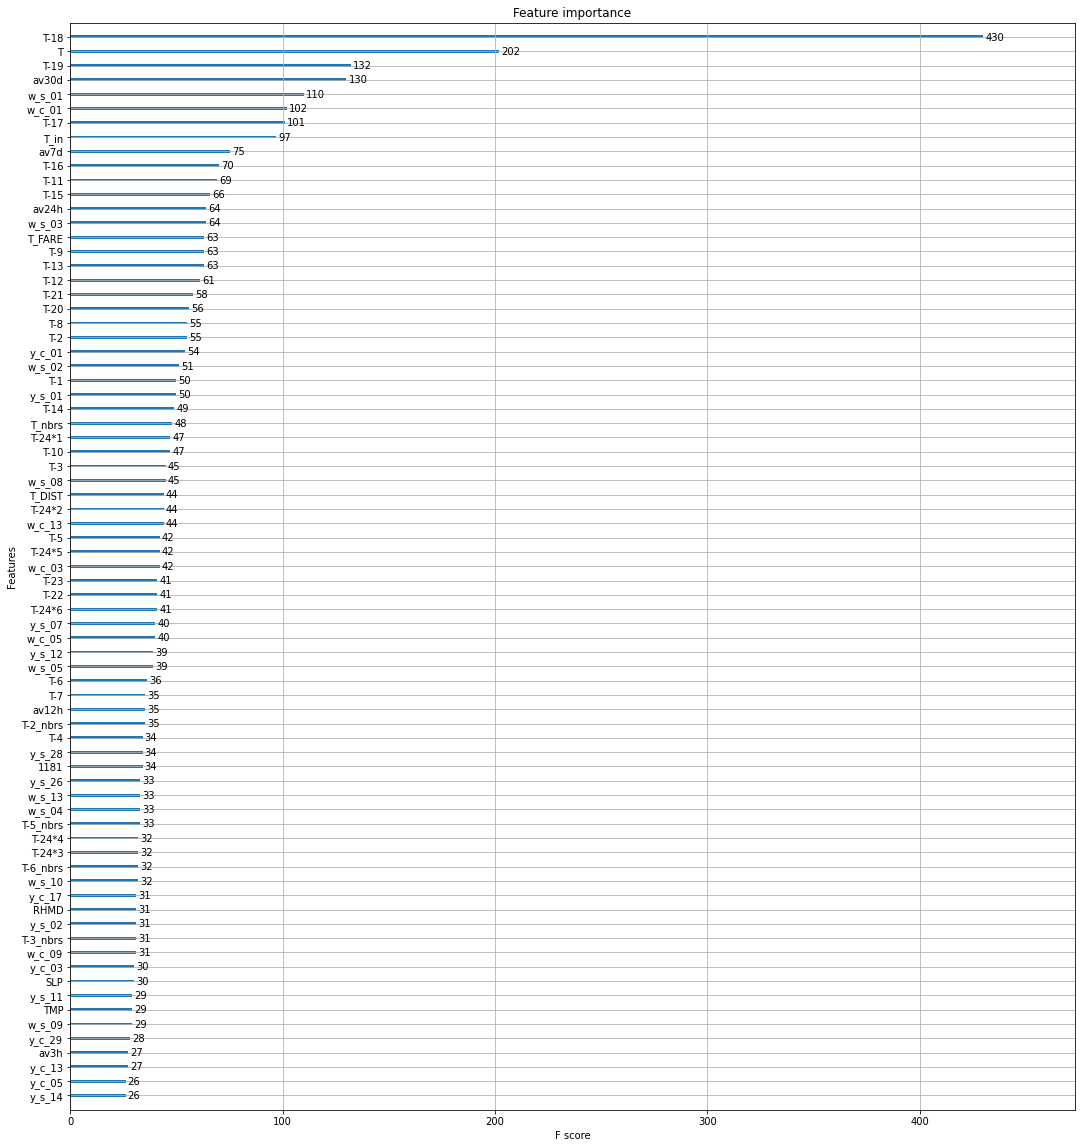

In [33]:
from xgboost import plot_importance
from matplotlib import pyplot

ax = plot_importance(xgb, max_num_features=75)
fig = ax.figure
fig.set_size_inches(18, 20)
pyplot.show()

Действительно, переменные T_in, T_nbrs (с некоторыми лагами), T_DIST, RHMD, SLP, TMP входят в число наиболее значимых. 

**3. Когда вы примете решение остановиться и перестать добавлять признаки, постройте для каждой географической зоны и каждого конца истории от 2016.04.30 23:00 до 2016.05.31 17:00 прогнозы на 6 часов вперёд; посчитайте в ноутбуке ошибку прогноза по следующему функционалу:** 
\begin{equation}
Q_{may} = \frac{1}{R \cdot 739 \cdot 6} \sum_{r = 1}^{R}\sum_{T = 2016.04.30\ 23:00}^{2016.05.31\ 17:00}\sum_{i = 1}^{6} |\hat{y}^r_{T | T+ i} - y^r_{T + i}|.
\end{equation}
**Убедитесь, что среднее качество прогнозов увеличилось.**

Прогноз на май и подсчет средней ошибки с использованием функционала был осуществлен в конце предыдущего пункта.

**4. Переобучите итоговые модели на данных до мая 2016 включительно, постройте прогнозы на июнь для каждого конца истории от 2016.05.31 23:00 до 2016.06.30 17:00 и запишите все результаты в один файл в уже знакомом вам формате: geoID, histEndDay, histEndHour, step, y**



In [26]:
# Блок с повторной загрузкой данных, поскольку задание не выполнялось в один проход
import pickle

with open('./data/data_lin_regr.pkl', 'rb') as f:
    data_ = pickle.load(f)
    
from datetime import datetime

data_ = data_[data_.index >= datetime(2014, 12, 1)]

In [27]:
data_.drop(columns=['d%.2d' % i for i in range(1, 32)], inplace = True)

import itertools
import math

cells = data_.columns[1:103]
for i in range(24):
    data_['d_s_%.2d' % i] = list(itertools.chain.from_iterable([[math.sin(x * 2 * math.pi * i / 24) for x in list(range(len(data_['T'][data_[cell] == 1].index)))] 
                                                                for cell in cells]))
    data_['d_c_%.2d' % i] = list(itertools.chain.from_iterable([[math.cos(x * 2 * math.pi * i / 24) for x in list(range(len(data_['T'][data_[cell] == 1].index)))] 
                                                                for cell in cells]))

In [28]:
import pandas as pd

start_date = '2014-12'
end_date = '2016-06'

working_dates = pd.date_range(start=start_date + '-01', end=end_date + '-01', freq='MS')

dt_DO = pd.DataFrame(columns=cells)
dt_Di = pd.DataFrame(columns=cells)
dt_Pa = pd.DataFrame(columns=cells)
dt_Fa = pd.DataFrame(columns=cells)
for date_ in working_dates:
    path_ = './data/yellow_tripdata_' + date_.strftime('%Y-%m') + 'DropOff.pkl'
    with open(path_, 'rb') as f:
        data_tmp = pickle.load(f)
        dt_DO = dt_DO.append(pd.DataFrame(data_tmp[cells]))
    
    path_ = './data/yellow_tripdata_' + date_.strftime('%Y-%m') + 'DIST.pkl'
    with open(path_, 'rb') as f:
        data_tmp = pickle.load(f)
        dt_Di = dt_Di.append(pd.DataFrame(data_tmp[cells]))
    
    path_ = './data/yellow_tripdata_' + date_.strftime('%Y-%m') + 'PASS.pkl'
    with open(path_, 'rb') as f:
        data_tmp = pickle.load(f)
        dt_Pa = dt_Pa.append(pd.DataFrame(data_tmp[cells]))
        
    path_ = './data/yellow_tripdata_' + date_.strftime('%Y-%m') + 'FARE.pkl'
    with open(path_, 'rb') as f:
        data_tmp = pickle.load(f)
        dt_Fa = dt_Fa.append(pd.DataFrame(data_tmp[cells]))
        
dt_DO = pd.concat([pd.DataFrame([list(dt_DO[cell].values), [cell] * len(dt_DO[cell])], 
                                 index=['T_in', 'cell'], 
                                 columns=dt_DO[cell].index).T for cell in cells])
dt_Di = pd.concat([pd.DataFrame([list(dt_Di[cell].values), [cell] * len(dt_Di[cell])], 
                                 index=['T_DIST', 'cell'], 
                                 columns=dt_Di[cell].index).T for cell in cells])
dt_Pa = pd.concat([pd.DataFrame([list(dt_Pa[cell].values), [cell] * len(dt_Pa[cell])], 
                                 index=['T_PASS', 'cell'], 
                                 columns=dt_Pa[cell].index).T for cell in cells])
dt_Fa = pd.concat([pd.DataFrame([list(dt_Fa[cell].values), [cell] * len(dt_Fa[cell])], 
                                 index=['T_FARE', 'cell'], 
                                 columns=dt_Fa[cell].index).T for cell in cells])
data_additional = pd.concat([dt_DO, dt_Di['T_DIST'], dt_Pa['T_PASS'], dt_Fa['T_FARE']], axis=1)

data_additional['cell'] = data_additional['cell'].astype(int)

for i in range(1, 7):
    data_additional['T_in-' + str(i)] = list(itertools.chain.from_iterable([data_additional['T_in'][data_additional['cell'] == cell].shift(i).values 
                                                                            for cell in cells]))
    data_additional['T_DIST-' + str(i)] = list(itertools.chain.from_iterable([data_additional['T_DIST'][data_additional['cell'] == cell].shift(i).values 
                                                                              for cell in cells]))
    data_additional['T_PASS-' + str(i)] = list(itertools.chain.from_iterable([data_additional['T_PASS'][data_additional['cell'] == cell].shift(i).values 
                                                                              for cell in cells]))
    data_additional['T_FARE-' + str(i)] = list(itertools.chain.from_iterable([data_additional['T_FARE'][data_additional['cell'] == cell].shift(i).values 
                                                                              for cell in cells]))

data_additional = data_additional[data_additional.index >= datetime(2014, 12, 1)]

In [31]:
data_ = pd.concat([data_, data_additional[[x for x in data_additional.drop(columns='cell').columns]]], axis=1)

In [32]:
del data_additional

In [33]:
data_ = data_[data_.index >= datetime(2014, 12, 31, 23)]

In [34]:
neighbours = list()
for i in cells:
    cell_nbrs = list()
    if i + 1 in cells:
        cell_nbrs.append(i + 1)
    if i - 1 in cells:
        cell_nbrs.append(i - 1)
    if i + 50 in cells:
        cell_nbrs.append(i + 50)
    if i - 50 in cells:
        cell_nbrs.append(i - 50)
    if i - 51 in cells:
        cell_nbrs.append(i - 51)
    if i - 49 in cells:
        cell_nbrs.append(i - 49)
    if i + 51 in cells:
        cell_nbrs.append(i + 51)
    if i + 49 in cells:
        cell_nbrs.append(i + 49)
    neighbours.append(cell_nbrs)

In [35]:
import itertools

avrg_nbrs = list()
for i in range(len(cells)):
    nbrs_T = list()
    for i_nbrs in neighbours[i]:
        nbrs_T.append(data_['T'][data_[i_nbrs] == 1])
    avrg_nbrs.append(sum(nbrs_T) / len(neighbours[i]))
data_['T_nbrs'] = list(itertools.chain(*avrg_nbrs))   

In [36]:
for lag_ in range(1, 7):
    avrg_nbrs = list()
    for i in range(len(cells)):
        nbrs_T = list()
        for i_nbrs in neighbours[i]:
            nbrs_T.append(data_['T-' + str(lag_)][data_[i_nbrs] == 1])
        avrg_nbrs.append(sum(nbrs_T) / len(neighbours[i]))
    data_['T-' + str(lag_) + '_nbrs'] = list(itertools.chain(*avrg_nbrs)) 

In [37]:
data_

,T,1075,1076,1077,1125,1126,1127,1128,1129,1130,...,T_DIST-6,T_PASS-6,T_FARE-6,T_nbrs,T-1_nbrs,T-2_nbrs,T-3_nbrs,T-4_nbrs,T-5_nbrs,T-6_nbrs
2014-12-31 23:00:00,54.0,1,0,0,0,0,0,0,0,0,...,3.421500,1.912500,13.156250,148.666667,231.000000,264.666667,261.333333,241.333333,210.666667,192.333333
2015-01-01 00:00:00,102.0,1,0,0,0,0,0,0,0,0,...,4.135500,1.912500,15.081250,174.333333,148.666667,231.000000,264.666667,261.333333,241.333333,210.666667
2015-01-01 01:00:00,134.0,1,0,0,0,0,0,0,0,0,...,3.267288,1.559322,12.237288,256.666667,174.333333,148.666667,231.000000,264.666667,261.333333,241.333333
2015-01-01 02:00:00,99.0,1,0,0,0,0,0,0,0,0,...,3.645778,1.922222,13.488889,226.000000,256.666667,174.333333,148.666667,231.000000,264.666667,261.333333
2015-01-01 03:00:00,80.0,1,0,0,0,0,0,0,0,0,...,3.716729,1.813084,13.532710,173.333333,226.000000,256.666667,174.333333,148.666667,231.000000,264.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-06-30 19:00:00,1.0,0,0,0,0,0,0,0,0,0,...,18.438333,1.500000,50.312500,119.000000,159.500000,169.500000,142.500000,133.500000,159.000000,122.000000
2016-06-30 20:00:00,0.0,0,0,0,0,0,0,0,0,0,...,19.183333,1.500000,52.000000,177.000000,119.000000,159.500000,169.500000,142.500000,133.500000,159.000000
2016-06-30 21:00:00,1.0,0,0,0,0,0,0,0,0,0,...,18.857353,1.911765,51.779412,177.500000,177.000000,119.000000,159.500000,169.500000,142.500000,133.500000
2016-06-30 22:00:00,0.0,0,0,0,0,0,0,0,0,0,...,16.654000,1.700000,50.316667,176.000000,177.500000,177.000000,119.000000,159.500000,169.500000,142.500000


In [38]:
data_['airport'] = data_[1684] + data_[1733] + data_[1734] + data_[1783] + data_[2068] + data_[2069] + data_[2118] + data_[2119] + data_[2168]

In [39]:
weather_data = pd.read_csv('https://www.ncei.noaa.gov/data/global-hourly/access/2014/72505394728.csv', low_memory=False)
weather_data = pd.concat([weather_data, pd.read_csv('https://www.ncei.noaa.gov/data/global-hourly/access/2015/72505394728.csv', low_memory=False)])
weather_data = pd.concat([weather_data, pd.read_csv('https://www.ncei.noaa.gov/data/global-hourly/access/2016/72505394728.csv', low_memory=False)])

In [40]:
weather_data[['DATE', 'TMP', 'DEW', 'SLP', 'VIS', 'WND', 'CIG']]

,DATE,TMP,DEW,SLP,VIS,WND,CIG
0,2014-01-01T00:51:00,"-0011,5","-0111,5","10221,5","016093,5,N,5","290,5,N,0046,5","22000,5,9,N"
1,2014-01-01T01:51:00,"-0011,5","-0117,5","10230,5","016093,5,N,5","290,5,V,0036,5","22000,5,9,N"
2,2014-01-01T02:51:00,"-0022,5","-0133,5","10240,5","016093,5,N,5","300,5,N,0036,5","22000,5,9,N"
3,2014-01-01T03:51:00,"-0028,5","-0150,5","10245,5","016093,5,N,5","999,9,V,0031,5","22000,5,9,N"
4,2014-01-01T04:51:00,"-0033,5","-0150,5","10252,5","016093,5,N,5","290,5,N,0046,5","22000,5,9,N"
...,...,...,...,...,...,...,...
11032,2016-12-31T19:51:00,"+0061,5","-0083,5","10150,5","016093,5,N,5","999,9,9,9999,9","22000,5,9,N"
11033,2016-12-31T20:51:00,"+0061,5","-0050,5","10147,5","016093,5,N,5","999,9,9,9999,9","22000,5,9,N"
11034,2016-12-31T21:51:00,"+0061,5","-0039,5","10147,5","016093,5,N,5","210,5,V,0041,5","22000,5,9,N"
11035,2016-12-31T22:51:00,"+0061,5","-0033,5","10140,5","016093,5,N,5","999,9,9,9999,9","22000,5,9,N"


In [41]:
weather_data['DATE'] = pd.to_datetime(weather_data['DATE'])
weather_data['TMP'] = [float(x[:5]) / 10 for x in weather_data['TMP']]
weather_data['DEW'] = [float(x[:5]) / 10 for x in weather_data['DEW']]
weather_data['SLP'] = [int(x[:5]) / 10 for x in weather_data['SLP']]
weather_data['VIS'] = [int(x[:6]) if x[7:8] in ['1', '5'] else 'NaN' for x in weather_data['VIS']]
weather_data['VIS'] = pd.to_numeric(weather_data['VIS'], errors='coerce').fillna(method='ffill')
weather_data['WND'] = [int(x[8:12]) / 10 if x[13:] in ['1', '5'] else 'NaN' for x in weather_data['WND']]
weather_data['WND'] = pd.to_numeric(weather_data['WND'], errors='coerce').fillna(method='ffill')
weather_data['CIG_H'] = [int(x[:5]) if x[6:7] in ['1', '5'] else 'NaN' for x in weather_data['CIG']]
weather_data['CIG_H'] = pd.to_numeric(weather_data['CIG_H'], errors='coerce').fillna(method='ffill')
weather_data['CIG_D'] = [x[8:9] if x[10:] in ['N', 'Y'] else 'NaN' for x in weather_data['CIG']]

from metpy.calc import relative_humidity_from_dewpoint
from metpy.units import units

from meteocalc import feels_like

weather_data['RHMD'] = [float(relative_humidity_from_dewpoint((x * units.degC).to(units.K), (y * units.degC).to(units.K)) * 100)
                        for (x, y) in zip(weather_data['TMP'], weather_data['DEW'])]
weather_data['TMP_FL'] = [float(feels_like(temperature=x, humidity=y, wind_speed=z)) for (x, y, z) 
                          in zip(weather_data['TMP'], weather_data['RHMD'], [x if isinstance(x, float) else 0 for x in weather_data['WND']])]

weather_data['STRM'] = [1 if x >=10.8 else 0 for x in weather_data['WND']]

weather_data = weather_data[weather_data['DATE'].apply(lambda x: x.minute) == 51]
weather_data['DATE'] = weather_data['DATE'].apply(lambda x: x.strftime('%Y-%m-%d %H:00:00'))
weather_data.index = weather_data['DATE'].values
weather_data.drop(columns=['DATE'], inplace=True)

weather_data = pd.concat([weather_data[['TMP', 'TMP_FL', 'WND', 'STRM', 'SLP', 'RHMD', 'VIS', 'CIG_H', 'REM']], pd.get_dummies(weather_data['CIG_D'], prefix='CIG_D')], axis=1)

weather_obs = {'FG': 'Fog, ice fog or freezing fog (may include heavy fog)',
               'FG+': 'Heavy fog or heavy freezing fog (not always distinguished from fog)',
               'TS': 'Thunder',
               'PL': 'Ice pellets, sleet, snow pellets or small hail',
               'GR': 'Hail (may include small hail)',
               'GL': 'Glaze or rime',
               'DU': 'Dust, volcanic ash, blowing dust, blowing sand or blowing obstruction',
               'HZ': 'Smoke or haze',
               'BLSN': 'Blowing or drifting snow',
               'FC': 'Tornado, water spout or funnel cloud',
               'WIND': 'High or damaging winds',
               'BLPY': 'Blowing spray',
               'BR': 'Mist',
               'DZ': 'Drizzle',
               'FZDZ': 'Freezing drizzle',
               'RA': 'Rain',
               'FZRA': 'Freezing rain',
               'SN': 'Snow, snow pellets, snow grains or ice crystals',
               'UP': 'Unknown precipitation',
               'MIFG': 'Ground fog',
               'FZFG': 'Ice fog or freezing fog'}

weather_data['REM'] = weather_data['REM'].str.split(" ")
for ind, item in weather_data['REM'].items():
    for obs in weather_obs.keys():
        if obs in item:
            weather_data.at[ind, obs] = 1

weather_data = pd.concat([weather_data.drop(columns=list(weather_obs.keys() & weather_data.columns)), 
                          weather_data[weather_obs.keys() & weather_data.columns].fillna(0)], 
                         axis=1)
weather_data.drop(columns='REM', inplace=True)

In [42]:
weather_data

,TMP,TMP_FL,WND,STRM,SLP,RHMD,VIS,CIG_H,CIG_D_9,CIG_D_M,CIG_D_W,FG,UP,FZFG,RA,SN,BR,FZRA,HZ
2014-01-01 00:00:00,-1.1,-11.180975,4.6,0,1022.1,46.590322,16093.0,22000.0,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2014-01-01 01:00:00,-1.1,-9.402666,3.6,0,1023.0,44.410263,16093.0,22000.0,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2014-01-01 02:00:00,-2.2,-10.663530,3.6,0,1024.0,42.324805,16093.0,22000.0,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2014-01-01 03:00:00,-2.8,-10.279123,3.1,0,1024.5,38.504088,16093.0,22000.0,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2014-01-01 04:00:00,-3.3,-13.748879,4.6,0,1025.2,39.963804,16093.0,22000.0,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-31 19:00:00,6.1,6.100000,1.5,0,1015.0,34.805401,16093.0,22000.0,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-12-31 20:00:00,6.1,6.100000,1.5,0,1014.7,44.830602,16093.0,22000.0,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-12-31 21:00:00,6.1,-2.005112,4.1,0,1014.7,48.701722,16093.0,22000.0,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-12-31 22:00:00,6.1,-2.005112,4.1,0,1014.0,50.936056,16093.0,22000.0,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [43]:
weather_data.index = pd.to_datetime(weather_data.index)
weather_data = weather_data[(weather_data.index >= datetime(2014, 12, 1)) & (weather_data.index <= datetime(2016, 6, 30, 23))]

weather_data = weather_data.reindex(index=data_.index.unique()).fillna(method='ffill')

In [44]:
weather_data

,TMP,TMP_FL,WND,STRM,SLP,RHMD,VIS,CIG_H,CIG_D_9,CIG_D_M,CIG_D_W,FG,UP,FZFG,RA,SN,BR,FZRA,HZ
2014-12-31 23:00:00,-1.1,-1.1,1.5,0.0,1024.0,37.174119,16093.0,22000.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2015-01-01 00:00:00,-1.1,-1.1,2.1,0.0,1023.5,37.174119,16093.0,22000.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2015-01-01 01:00:00,-1.1,-1.1,1.5,0.0,1023.0,35.684420,16093.0,22000.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2015-01-01 02:00:00,-1.1,-1.1,2.1,0.0,1022.3,39.034919,16093.0,22000.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2015-01-01 03:00:00,-1.7,-1.7,2.1,0.0,1022.0,42.479043,16093.0,22000.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-06-30 19:00:00,28.9,28.9,2.1,0.0,1015.1,35.643382,16093.0,22000.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-06-30 20:00:00,28.9,28.9,2.1,0.0,1015.0,37.075465,16093.0,22000.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-06-30 21:00:00,27.2,27.2,2.1,0.0,1015.4,43.986900,16093.0,22000.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-06-30 22:00:00,25.6,25.6,1.5,0.0,1015.9,51.910840,16093.0,22000.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [45]:
data_ = data_.merge(weather_data, left_on=data_.index, right_on=weather_data.index, validate='m:m')
data_.index = data_['key_0'].values
data_.drop(columns='key_0', inplace=True)
data_

,T,1075,1076,1077,1125,1126,1127,1128,1129,1130,...,CIG_D_M,CIG_D_W,FG,UP,FZFG,RA,SN,BR,FZRA,HZ
2014-12-31 23:00:00,54.0,1,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2014-12-31 23:00:00,103.0,0,1,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2014-12-31 23:00:00,52.0,0,0,1,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2014-12-31 23:00:00,66.0,0,0,0,1,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2014-12-31 23:00:00,277.0,0,0,0,0,1,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-06-30 23:00:00,147.0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-06-30 23:00:00,38.0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-06-30 23:00:00,173.0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-06-30 23:00:00,119.0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Теперь разделим выборку на обучающую и тестовую (июнь) и обучим модели, подсчитав ошибку.

In [46]:
X = data_.drop(columns=['T+1', 'T+2', 'T+3', 'T+4', 'T+5', 'T+6'])
Y = data_[['T+1', 'T+2', 'T+3', 'T+4', 'T+5', 'T+6']]
del data_

In [47]:
X_control = X[X.index >= datetime(2016, 5, 31, 23)]
Y_control = Y[Y.index >= datetime(2016, 5, 31, 23)]

In [48]:
X_control = X_control[X_control.index <= datetime(2016, 6, 30, 17)]
Y_control = Y_control[Y_control.index <= datetime(2016, 6, 30, 17)]

In [49]:
Y_train = Y[Y.index <= datetime(2016, 5, 31, 17)]
del Y

In [50]:
X_train = X[X.index <= datetime(2016, 5, 31, 17)]
del X

In [52]:
from xgboost import XGBRegressor
from sklearn import metrics

MAE_xgb = list()
predictions = list()
for i in range(1, 7):
    err = -1
    xgb = XGBRegressor(learning_rate=1, n_estimators=100,
                       reg_alpha=1, reg_lambda=0.1, n_jobs=-1).fit(X_train, Y_train['T+' + str(i)])
    pred_xgb = xgb.predict(X_control)
    pred_xgb[pred_xgb < 0] = 0
    predictions.append(pred_xgb)
    err = metrics.mean_absolute_error(Y_control['T+' + str(i)], pred_xgb)
    MAE_xgb.append(err)
    print('Модель: T+%.d Ошибка: %.2f' % (i, err))

Модель: T+1 Ошибка: 17.51
Модель: T+2 Ошибка: 21.43
Модель: T+3 Ошибка: 21.83
Модель: T+4 Ошибка: 21.79
Модель: T+5 Ошибка: 23.54
Модель: T+6 Ошибка: 23.16


Средняя ошибка прогнозов на июнь:

In [53]:
sum(MAE_xgb) / 6

21.54475678545515

Ошибка уменьшилась на 0,5. Добавление лагов к новым переменным из сырых данных значительно прогноз не изменило. Возможные пути улучшения модели - это использование другой модели (например случайный лес) или усложнение действующей модели (пробовать использовать большее количество данных, увеличить количество эстиматоров).

Сформируем датафрейм для записи в файл для отправки на сайте Kaggle.

In [54]:
for i in range(1, 7):
    X_control['T+%.d' % i] = predictions[i - 1]

In [56]:
#cells = X_control.columns[1:103]
for cell in cells:
    X_control[cell] = [cell if x == 1 else 0 for x in X_control[cell]]
X_control['cell'] = X_control[cells].sum(axis=1)

При прогнозировании отрицательные значения количества поездок заменялись нулем. При формировании датафрейма еще и округлим их до целого.

In [57]:
data_for_output = list()
for item in X_control[['cell', 'T+1', 'T+2', 'T+3', 'T+4', 'T+5', 'T+6']].iterrows():
    for i in range(1, 7):
        data_for_output.append({'id': str(int(item[1]['cell'])) + '_' + str(item[0].strftime('%Y-%m-%d')) + '_' + str(int(item[0].strftime('%H'))) + '_' + str(i),
                                'y': int(item[1]['T+%.d' % i])})
data_for_output = pd.DataFrame(data_for_output)

In [58]:
data_for_output

,id,y
0,1075_2016-05-31_23_1,32
1,1075_2016-05-31_23_2,6
2,1075_2016-05-31_23_3,4
3,1075_2016-05-31_23_4,0
4,1075_2016-05-31_23_5,5
...,...,...
437575,2168_2016-06-30_17_2,14
437576,2168_2016-06-30_17_3,7
437577,2168_2016-06-30_17_4,4
437578,2168_2016-06-30_17_5,27


In [59]:
data_for_output[['id', 'y']].to_csv('./data/Q_xgb_june_last.csv', index=False)

**5. Загрузите полученный файл на kaggle: https://inclass.kaggle.com/c/yellowtaxi. Добавьте в ноутбук ссылку на сабмишн.**

Прилагаю скриншот сабмишна.

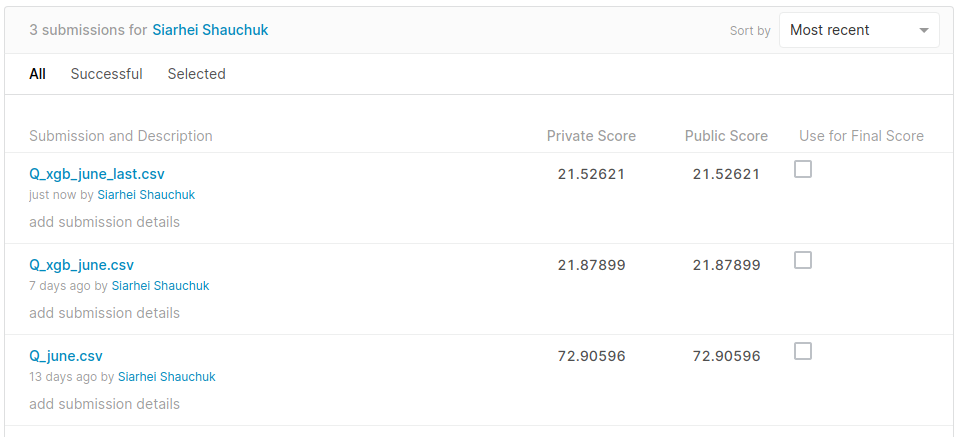